In [1]:
import matplotlib.pyplot as plt
import optax
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import StronglyEntanglingLayers
import jax
import jax.numpy as jnp

key = jax.random.PRNGKey(42)

In [2]:
coeffs = [(0.11 + 0.11j), (0.2 + 0.2j), (0.3 + 0.3j), (0.5 + 0.5j), (0.7 + 0.7j), (1.1 + 1.1j)]
coeffs = [(0.5 + 0.5j), (1.1 + 1.1j), (0.2 + 0.2j), (0.7 + 0.7j), (0.11 + 0.11j), (0.3 + 0.3j)]
coeffs = [
    (0.3  + 0.5j),   # c_1
    (0.7  + 0.11j),  # c_2
    (0.13 + 0.17j),  # c_3
    (0.19 + 0.23j),  # c_4
    (0.29 + 0.31j),  # c_5
]

c0 = 0.0
scaling = 1

def target_function(x):
    res = c0
    for idx, c in enumerate(coeffs):
        exponent = scaling * (idx + 1) * x * 1j
        conj_c = jnp.conjugate(c)
        res += c * jnp.exp(exponent) + conj_c * jnp.exp(-exponent)
    return jnp.real(res)

def minmax_scaler(y):
    # Scale y to [0, 1]
    y_min = jnp.min(y)
    y_max = jnp.max(y)
    y_scaled = (y - y_min) / (y_max - y_min)
    return y_scaled

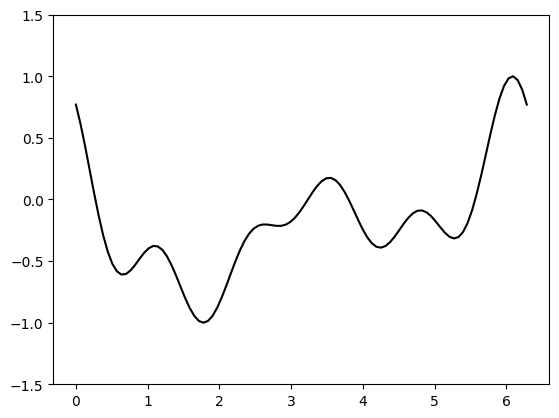

In [3]:
x_raw = jnp.linspace(-12, 12, 100)
x = minmax_scaler(x_raw) * 2 * jnp.pi
target_y = jax.vmap(target_function)(x)

target_y_scaled = minmax_scaler(target_y) * 2 - 1

plt.plot(x, target_y_scaled, c="black")
# plt.scatter(x, target_y_scaled, facecolor="white", edgecolor="black")
plt.ylim(-1.5, 1.5)
plt.show()

In [42]:
r = 5
n_qubits = r
trainable_block_layers = 2

dev = qml.device("default.qubit", wires=r)

def S(x):
    """encoding block"""
    for w in range(r):
        qml.RX(scaling * x, wires=w)

def W(theta):
    """
    train block
    RY with RZZ all-to-all
    """
    # RY to each qubit
    for i in range(n_qubits):
        qml.RY(theta[i], wires=i)

    # RZZ to all qubit pairs (i ≠ j)
    idx = n_qubits
    for i in range(n_qubits):
        for j in range(i+1, n_qubits):
            qml.IsingZZ(theta[idx], wires=[i, j])
            idx += 1

    # RY to each qubit
    # for i in range(n_qubits):
    #     qml.RY(theta[idx], wires=i)
    #     idx += 1

@qml.qnode(dev, interface="jax")
def all_to_all_rzz(weights, x):

    for layer in range(trainable_block_layers):
        W(weights["W"][0][layer])

    # final RY to each qubit
    for i in range(n_qubits):
        qml.RY(weights["final"][0][i], wires=i)

    S(x)

    for layer in range(trainable_block_layers):
        W(weights["W"][1][layer])

    # final RY to each qubit
    for i in range(n_qubits):
        qml.RY(weights["final"][1][i], wires=i)

    return qml.expval(qml.PauliZ(0))

# @qml.qnode(dev, interface="jax")
# def quantum_model(weights, x):
#
#     W(weights[0])
#     S(x)
#     W(weights[1])
#
#     return qml.expval(qml.PauliZ(4))

jit_model = jax.jit(all_to_all_rzz)

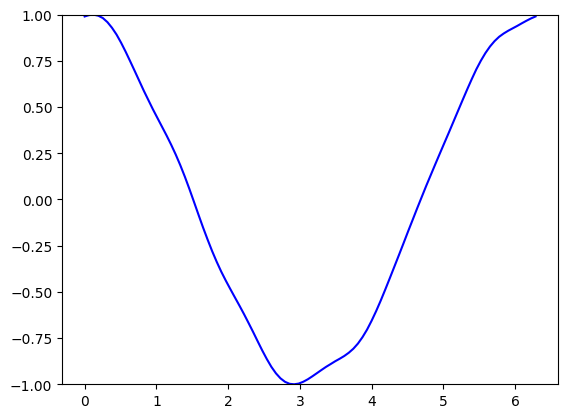

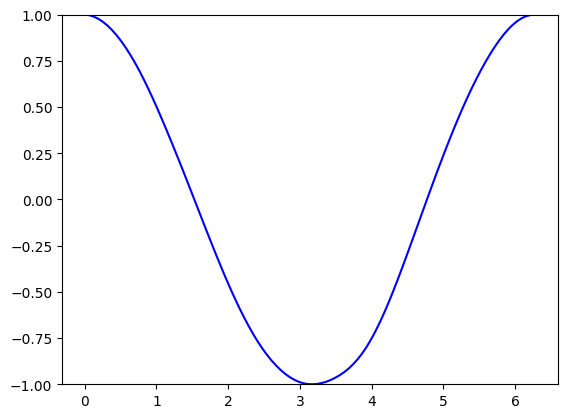

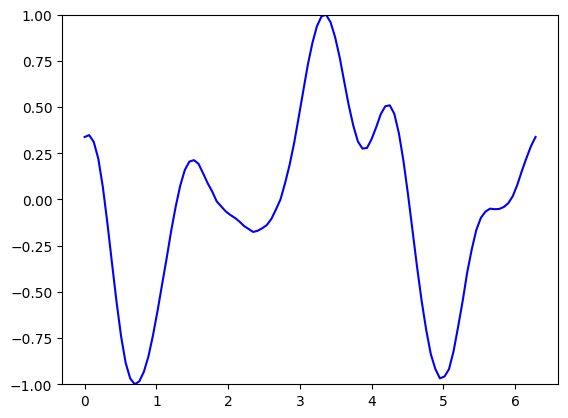

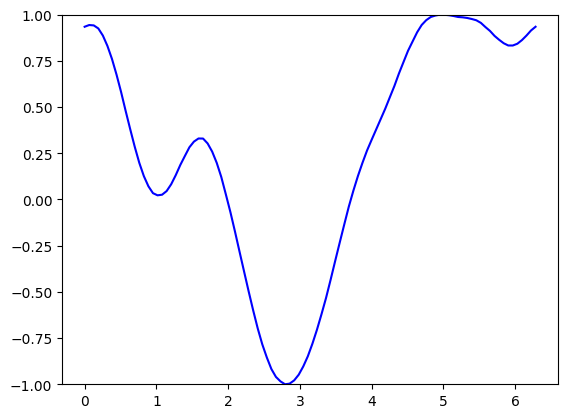

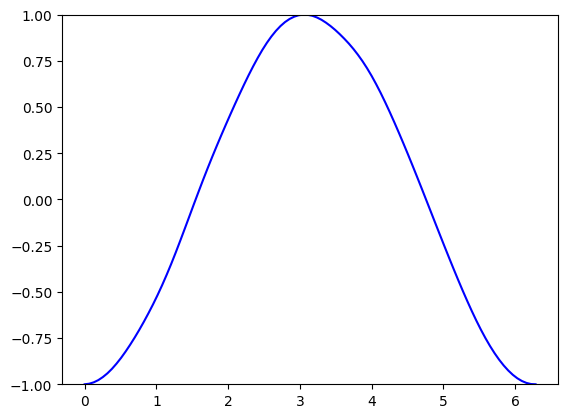

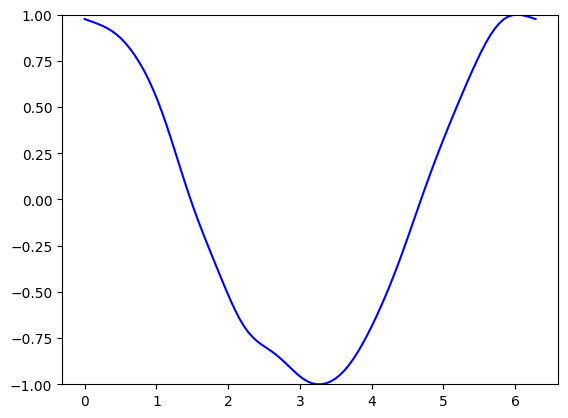

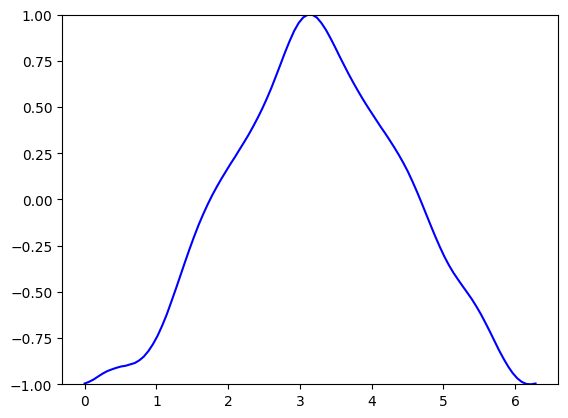

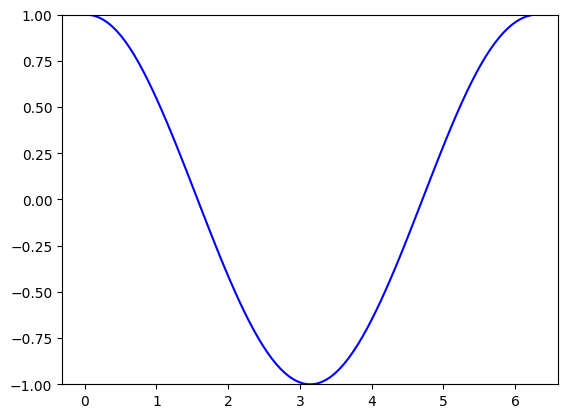

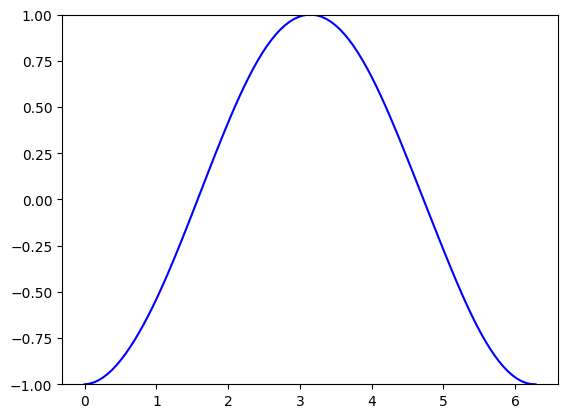

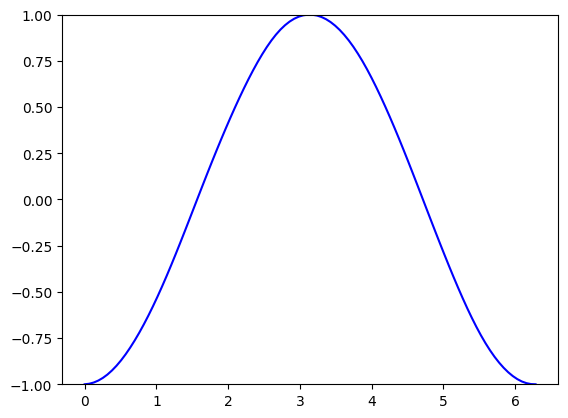

In [46]:
# number of params per layer, RY + all-to-all RZZ
layer_size = n_qubits + (n_qubits * (n_qubits - 1))//2

key, subkey1, subkey2 = jax.random.split(key, num=3)

W_weights = jax.random.uniform(subkey1, shape=(2, trainable_block_layers, layer_size), minval=0, maxval=2 * jnp.pi)
final_ry_weights = jax.random.uniform(subkey2, shape=(2, n_qubits), minval=0, maxval=2 * jnp.pi)
weights = {"W": W_weights, "final": final_ry_weights}

# weights = jax.random.uniform(subkey1, shape=(trainable_block_layers, layer_size), minval=0, maxval=2 * jnp.pi)

print(qml.draw(all_to_all_rzz, level="device")(weights, x))

random_quantum_model_y = jax.vmap(lambda x_: jit_model(weights, x_))(x)
random_quantum_model_y_scaled = minmax_scaler(random_quantum_model_y) * 2 - 1

plt.plot(x, random_quantum_model_y_scaled, c="blue")
plt.ylim(-1, 1)
plt.show()

In [ ]:
def square_loss(targets, predictions):
    return 0.5 * jnp.mean((targets - predictions) ** 2)


def cost(weights, x, y):
    # predictions = jax.vmap(lambda x_: jit_model(weights, x_))(x)
    predictions = jit_model(weights, x)
    return square_loss(y, predictions)


class GradientLogger:
    def __init__(self):
        self.log = {
            "step": [],
            "loss": [],
            "grad_mean": [],
            "grad_std": [],
            "grad_min": [],
            "grad_max": [],
        }

    def get_gradients(self, weights, x, target_y):
        cost_fn = lambda w: cost(w, x, target_y)
        grads = jax.grad(cost_fn)(weights)

        # Flatten all gradient arrays into a single vector
        flat_grads = jnp.concatenate([jnp.ravel(g) for g in jax.tree_util.tree_leaves(grads)])

        return flat_grads

    def update(self, step, loss_val, flat_grads):
        self.log["step"].append(step)
        self.log["loss"].append(loss_val)
        self.log["grad_mean"].append(jnp.mean(flat_grads))
        self.log["grad_std"].append(jnp.std(flat_grads))
        self.log["grad_min"].append(jnp.min(flat_grads))
        self.log["grad_max"].append(jnp.max(flat_grads))

    def summary(self):
        return self.log

In [ ]:
opt = optax.adam(0.01)
opt_state = opt.init(weights)

@jax.jit
def update_step(weights, opt_state, x_batch, y_batch):
    loss, grads = jax.value_and_grad(cost)(weights, x_batch, y_batch)
    updates, opt_state = opt.update(grads, opt_state)
    weights = optax.apply_updates(weights, updates)
    return weights, opt_state, loss

max_steps = 1000
batch_size = 25
cst = [cost(weights, x, target_y)]  # initial cost
logger = GradientLogger()

for step in range(max_steps):
    key, subkey = jax.random.split(key)

    batch_index = jax.random.choice(subkey, len(x), (batch_size,), replace=False)
    x_batch = x[batch_index]
    y_batch = target_y_scaled[batch_index]

    weights, opt_state, _ = update_step(weights, opt_state, x_batch, y_batch)

    c = cost(weights, x, target_y_scaled)
    cst.append(c)

    grads = logger.get_gradients(weights, x, target_y_scaled)
    logger.update(step, c, grads)

    if (step + 1) % 10 == 0:
        print("Cost at step {0:3}: {1}".format(step + 1, c))

In [ ]:
predictions = jax.vmap(lambda x_: jit_model(weights, x_))(x)

plt.plot(x, target_y_scaled, c="black")
plt.scatter(x, target_y_scaled, facecolor="white", edgecolor="black")
plt.plot(x, predictions, c="red")
plt.ylim(-1, 1)
plt.show()

In [ ]:
plt.plot(range(len(cst)), cst)
plt.ylabel("Cost")
plt.xlabel("Step")
plt.ylim(0, 0.05)
plt.show()

In [ ]:
log = logger.summary()

plt.plot(log["step"], log["grad_std"])
plt.xlabel("Training Step")
plt.ylabel("Grad Std")
plt.show()

In [ ]:
def r2_score(y_true, y_pred):
    ss_resid = jnp.sum((y_true - y_pred) ** 2)
    ss_total = jnp.sum((y_true - jnp.mean(y_true)) ** 2)
    return 1 - ss_resid / ss_total


r2 = r2_score(target_y_scaled, jax.vmap(lambda x_: jit_model(weights, x_))(x))
r2